# UAVs and High Power Microwaves - An Analysis of the Threat and Shielding Options

## Introduction:

All major military powers (both friendly and otherwise) are now developing High Power Microwave devices to destroy vehicles/systems, with a particular focus on small unmanned aerial vehicles. Consequently, UAV designers must now take electromagnetic shielding into consideration. 

This document won't provide a complete design for a shielded UAV, but will show how to add shielding and calculate it's effects, as well as 'concept designs' of a few parts that could be used for shielding in an FPV drone.

## Some maths/attempt to quantify the problem:

Let's start with some straightforward maths in an attempt to provide an answer to the question - 'Exactly what level of shielding do we need to prevent our UAV's electronics being damaged by High Powered Microwaves'?

Firstly, some assumptions:

1. We are going to assume that the HPM device operates somewhere between 2 and 40 Ghz. This would cover most of S-Band as well as the X, Ku and Ka bands. The most likely frequency band of operation of the HPM device will probably be between 6 and 18 GHz due to the required compromise between antenna size and atmospheric attenuation but the others should be included as viable possibilities. This becomes important when we are looking at circular waveguide theory later on.

2. Directionality – We will always be considering ‘worst case scenario’. This would be an EM plane wave entering at ‘optimal’ angle from the PoV of the ‘threat’. Attempts to account for threat angle of approach would likely require EM solvers etc and my intention is to keep this document to a few simple formulas that can be understood with a knowledge of algebra and logarithms. 

3. Weakest point is always the limitation. So what this means is that if one component only provides 30db of protection when all the others provided 80db of protection, total shielding effectiveness will be considered to be 30db. This is a direct and logical consequence of assumption 2.

4. We will use fiber optic for the guidance/communication systems. Note that the dispenser etc are non-conductive so it does not matter if this is outside the shielding. This means we don't have to consider front door coupling.

Next let's look at how powerful an electical field has to be to cause damage to electronics: In a paper released by the US Air Force Research Lab<sup>1</sup>, they stated that the relevant fields strengths are 8 kV/m (upset) and 15 to 20 kV/m (damage). AFRL considers a field of electrical potential of 200 V/m or stronger as a threat to sensitive electronics in general.

From this we can see that we need to reduce the eletrical field generated as part of a High Powered Microwave to below 200V/m to prevent damage and interference. Then we need to specify some parameters for the HPM device and use case:

<b>Device power</b>: 5MW<br>
<b>Antenna gain</b>: 46dbi - This is based on a rough analysis of the diameter of the dish on the THoR system. If it were to operate at 8Ghz this is the gain that that the parabolic reflector on the system would provide.<br>
<b>Minimum distance from UAV to HPM device</b>: We are going to say that distance is 50m. This is based entirely on user requirements for the use case of the UAV (i.e. what is the closest the UAV needs to get to the HPM device).

Now we calculate the Effective Isotropic Radiated Power of the device, which will give us the magnitude of the electric field at the device in db:

$$EIRP@0 = P_T + G_a - SE $$

where:

$P_T$ - Transmitter Power (converted from KW to dbm)<br>
$G_a$ - Antenna Gain (dbi)<br>
$SE$ - Shielding Effectiveness on UAV(db) - not normally part of an EIRP calculation. Added to allow us check the effects of increasing the shielding on our UAV<br>

The rate of reduction in the electric field moving away from the device is proportional to 4$\pi$ times the radius squared. So lets do that to get it at the range we specified (50m).

$$EIRP@50m = \frac{EIRP@0}{4\pi r^2}$$

Finally, convert from db to W/m2 and then to v/m:

$$W/m^2 = \frac{10^\frac{EIRP@50m}{10}}{1000}$$

$$v/m = \sqrt{377 W/m^2}$$


The python code below will evaluate the equations above for our example:

In [44]:
import math

tgt_range = 50 # range in m from HPM device to UAV
transmitter_power = 5 # in megawatts in this case
shielding_value = 0 # shielding value in db
antenna_gain = 46 # in dbi

def to_dbm(value, input_units):

    if input_units == 'MILLIWATTS':
        return 10 * math.log10(value)
    if input_units == 'WATTS':
        return 10 * math.log10(value * 1e3)
    if input_units == 'KILOWATTS':
        return 10 * math.log10(value * 1e6)
    if input_units == 'MEGAWATTS':
        return 10 * math.log10(value * 1e9)
    if input_units == 'GIGAWATTS':
        return 10 * math.log10(value * 1e12)

def dbm_to_watts(value):

    return math.pow(10,(value/10))/1000

def field_strength_at_target(EIRP, range):

    EIRP = EIRP - shielding_value
    EIRP = dbm_to_watts(EIRP)
    return EIRP/(4 * math.pi * math.pow(range,2))

def convert_wm2_to_vm(value):

    return math.sqrt(377 * value)

EIRP_as_dbm = to_dbm(transmitter_power, 'MEGAWATTS')
EIRP_as_dbm = EIRP_as_dbm + antenna_gain
fst = field_strength_at_target(EIRP_as_dbm,tgt_range)
fs_target = convert_wm2_to_vm(field_strength_at_target(EIRP_as_dbm, tgt_range))

print("Electrical Field strength at UAV = %3d" % fs_target, "v/m")

Electrical Field strength at UAV = 48874 v/m


As the required field strength for destruction is 15,000 v/m, it's obvious that this device will likely cause catastrophic failure of the UAV.

So now we have calculated the electric field magnitude at that distance, we must find the shielding value required to 'reduce' the field to a level where it won't damage our electronics. By simply re-arranging our equations above, we can calculate that the value of shielding required to reduce the field strength to less than 200 v/m is 48db. We will now create some representative designs which provide this level of shielding for all components in line with assumption 3 above. 

## Shielding for Panels/Continuous Surfaces and Wires

I'm not going to dive too deeply into this one, as pages 19-30 in this document prepared for NASA<sup>2</sup> give a good explanation of how to calculate the Shielding Effectiveness of individual panels/pieces of materials if you want to get down that level. I will however reference a few figures in this same document to demonstrate a few 'ball park' ideas:

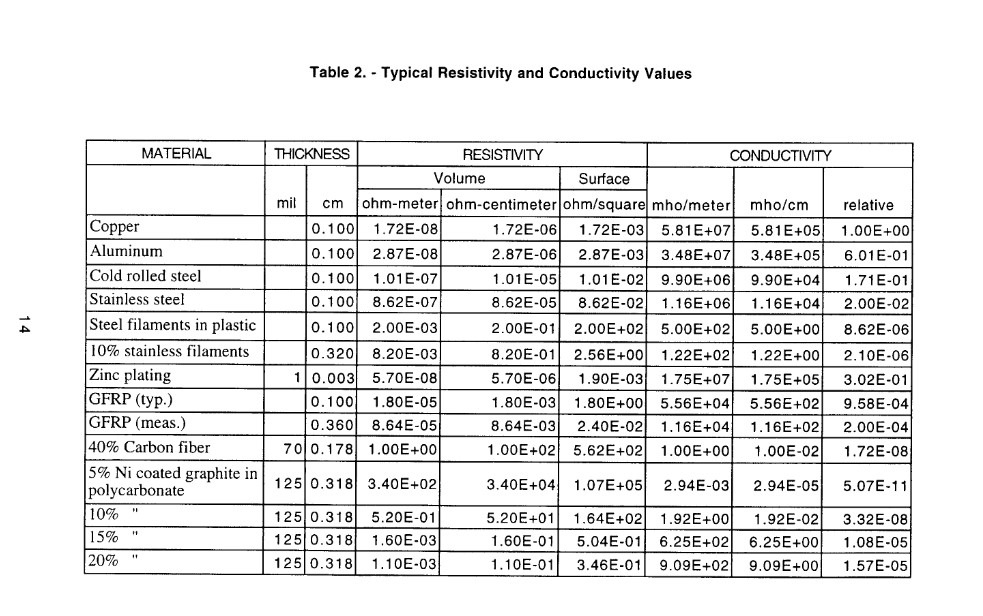


The below graph shows the relationship between surface resistivity and SE

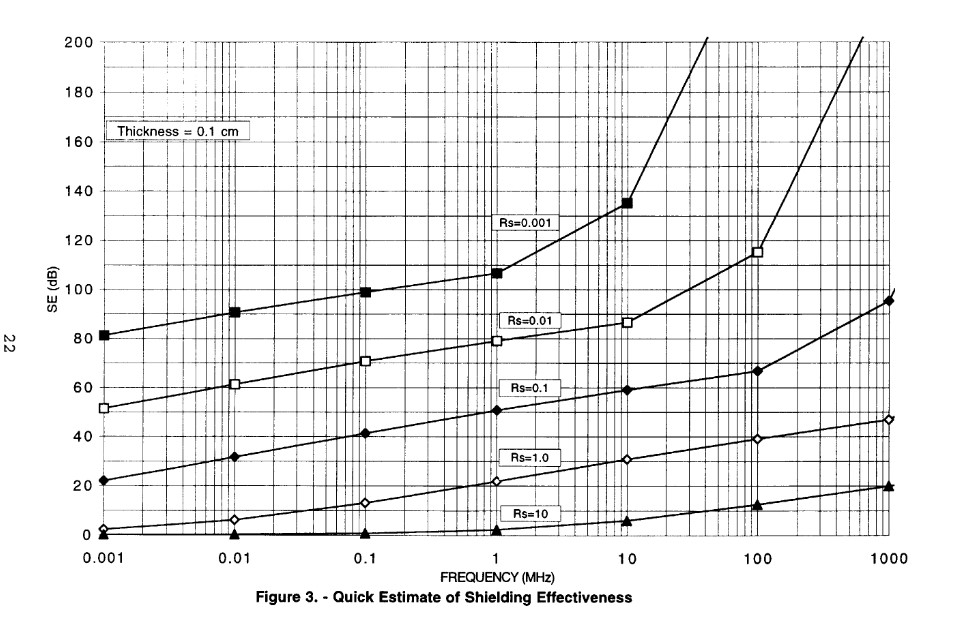

If we put these two figures together, we can see that a thin zinc plating will have an SE of over 200db at 1 Ghz. The key takeaway here is this:

**You don't actually need your conductive material to be very thick (or heavy) to provide good shielding. This is quite well known in industry and there are many tapes/cloths/flexible tubes/heat shrinks etc with embedded conductors produced by a variety of vendors for this purpose.**

This means that you can create an effective, lightweight shielded enclosure by essentially just by making a frame and correctly wrapping it in conductive tape/cloth. In a similar way, things like LiPo batteries etc can be wrapped, with all external wires also wrapped or just covered in conductive heat shrink/tubes. Gaskets are also available for insulating joints between conductive shields.

There is a trap here. Extreme care must be taken when applying conductive material not to have any 'gaps' which could allow microwaves to enter the shielded enclosure. Correctly applying materials deserves a whole write up of it's own and I can't do it justice in a single paragraph.

As an interesting aside here, we also now have conductive 3dp PLA/PLA+ available:

https://www.multi3dllc.com/product/electrifi/

This would make manufacturing some of the more complex shield designs referenced later in the document much easier (could all be done on a few hundred dollar Ender 3 printer), although it would also be subject to the standard limitations of PLA/PLA+ filament(don't leave it in a car on a hot day).

TODO/Placeholder : Also notable here that there are some EMI shielding glasses that we could use to improve our apetures below, however this requires more research on my part for a better understanding. Will get to this hopefully soon.

## But what about Ventilation?

So far we have looked at raw shielding values of materials and creating essentially 'solid' enclosures. But sometimes you need apetures in the enclosure for cooling and sensors. What happens if we just punch holes in the shielding material to allow this?

## Apetures:

Apetures (generally just holes) are required for cameras and other sensors as well as cooling. These apetures can obviously also allow microwaves to enter the shielding enclosure. But just how much difference can an apeture make? The shielding effectiveness of an apeture can be calculated as:

$$SE = 99 - 20 \log{f_tdi} + 3 + 30 \frac{dp}{di}$$

Where:
$f_t$ = Maximum threat frequency (Mhz)<br>
$di$ = Apeture diameter (mm)<br>
$dp$ = Apeture depth (mm)<br>

@TODO: I will eventually add an example here being of this being demonstrated with ADALM Pluto and HackRf One Software Defined Radios in the S-Band. If this line is still here, it means I haven’t got around to it yet.

So based on our previous design parameters as well as some new ones:

<b>Maximum threat frequency</b> = 40Ghz (Assumption 1)<br>
<b>Apeture Diameter</b> = 2mm - Derived from measurement of lens width of Raspberry Pi 2 Camera Module<br>
<b>Apeture Depth</b> = 0.25mm - Just a representative value for a thin sheet/coating of metal. Change as required<br>

In [45]:
import math

def calculate_apeture_shielding(diameter, frequency, depth):
    
    return (99 - (20*math.log10(diameter*frequency)) + 3 + 30 * (depth/diameter))

apeture_diameter = 2 #mm
apeture_depth = 0.25 #mm
max_frequency = 40000 #in MHz

SE = calculate_apeture_shielding(apeture_diameter,max_frequency, apeture_depth)

print("Shielding value of apeture is = %2d" % SE, "db")


Shielding value of apeture is =  7 db


So from this, we can see that just punching a hole in the thin main shielding panels significantly reduces the shielding effectiveness of the apeture. Note the last term in the equation 4 though. Due to the relationship between the apeture diameter and the apeture depth shielding effectiveness can be significantly increased by increasing the depth to diameter ratio of the apeture. As an example, consider if we change the depth to 4mm as opposed to the 0.25mm above:

In [46]:
### MUST RUN PREVIOUS CODE CELLS FIRST ###
apeture_diameter = 2 #mm
apeture_depth = 4 #mm
max_frequency = 40000 #in Mhz

SE = calculate_apeture_shielding(apeture_diameter,max_frequency, apeture_depth)

print("Shielding value of apeture is = %2d" % SE, "db")

Shielding value of apeture is = 63 db


However, this depth change could create other limitations. Let's say we need a camera (generally a pretty universal requirement for a UAV). Let's try using a deeper apeture (case b above) to protect the camera electronics. From our calculation, we can see it will provide good shielding, but will also likely limit the camera FoV. First of all, the theoretical calculation (glossing over this as it's not particularly relevant to HPM):

If we split the FoV available through the apeture in half we end up with two identifcal right angled triangles. Each of these triangles will have one side with a dimension of $\frac{diameter}{2}$, another side with a dimension of $depth$ and a hypotenuse with a length of $\sqrt{\frac{diameter}{2}^2+depth^2}$

So total equation for field of view angle will be: $$2 * arctan(\frac{\frac{diameter}{2}}{depth})$$

In [47]:
import math

apeture_diameter = 2 ## mm
apeture_depth = 4 ## mm

apeture_fov = 2 * math.degrees(math.atan((apeture_diameter/2)/apeture_depth))

print("Apeture Field of View = %2d" % apeture_fov, "degrees")

Apeture Field of View = 28 degrees


So our camera will be limited to a circular (as the apeture is circular) FoV of 28 degrees.

@TODO: For a 'real world' demonstration of this, I will 3d print a camera shield with the parameters above for the Raspberry Pi 2 camera module. I will then run this on a Jetson to give a demo of the FoV limitation.

The calculation show that the field of view is limited. A gimbal will also be required. Building the gimbal is once again a ‘copy paste’ of the concepts described above (EMI heatshrink or tape for the wiring, vented panels for the stepper motors if required, waveguides/deep apetures for any motor shafts etc). @TODO: I may expand this part into an example design at some point. Once again, if this is still here I haven't got round to it yet.

Despite the limited FoV, this system would be usable (if somewhat of a handicap) for something like a basic FPV drone where you are just trying to work out where you are going, but would obviously be a bigger handicap for a reconnaissance drone.


## Waveguides:


The reason we are interested in waveguides is that the function of waveguides is also frequency dependent. Waveguides also act as a high pass filter, attenuating the EM wave as opposed to magnifying it once the frequency exceeds a certain value (cut-off frequency). This is what happens in our deep apetures when the length of our apeture exceeds the diameter - it essentially becomes a waveguide. We can calculate the cut-off frequency for a waveguide with this formula:  

$$f_c = \frac{1.8412c}{2\pi r}$$

Where:

$f_c$ = cutoff frequency (GHz)<br>
$c$ = speed of light (m/s)<br>
$r$ = radius of the waveguide (cm)<br>

After we have calculated this cut-off frequency, we can calculate the shielding effects of a circular waveguide using this formula:

$$SE = 32 \frac{l}{d} \sqrt{1-(\frac{f_t}{f_c})^2}$$

Where:

$l$ = Length of the waveguide (cm)<br>
$d$ = Diameter of the waveguide (cm)<br>
$f_t$ = Highest frequency of threat (GHz)<br>
$f_c$ = Cutoff frequency (GHz)<br>

Length/diameter relationship is important. Any waveguide where the diameter is greater than the length of the waveguide will be able to transmit microwaves via a different mode and the ‘high pass filter’ effect will no longer be reliable. Shielding effectiveness will also be increased as the waveguide gets longer. Most texts suggest that the waveguide length should be at least twice it's diameter(generally more) to ensure correct function.

There is also believed to be a 'coupling effect' between waveguides, which reduces the shielding if waveguides are created in the same conductive material with less than $\frac{\lambda}{2}$ (where $\lambda$ is the wavelength of the highest frequency of threat) distance between them. The formula to calculate this effect is:

$$CE = -10\log{n_c}$$

Where:

$CE$ = Coupling effect (db)<br>
$n_c$ = Number of Cells subject to coupling effect - this is determined by number of waveguides on physical design.

So from all these formula's we can design a panel to provide ventilation for our 'theoretical' FPV drone. We will look at creating the front and rear panels to allow air flow. Let's do an example calculation in the python code below:

Input parameters will be:

<b>Waveguide length</b> = 3.5mm<br>
<b>Waveguide diameter</b> = 1mm<br>
<b>Panel width</b> = 60mm<br>
<b>Panel height</b> = 40mm<br>
<b>Number of cells</b> = 375<br>

The area 5mm in from each edge of the panel will be solid material to allow better overlap between shielding fabrics/tape and better attachment points.

In [48]:
import math

speed_of_light = 3e8 # m/s


def add_coupling_effects(number_of_cells):

    # Used when distance between cells <l/2
    return -10 * math.log10(number_of_cells) # return value is in db


def circular_waveguide_cutoff(radius):

    # cm in - GHZ out
    return ((1.8412 * speed_of_light) / (2 * math.pi * radius)) * 1e-7 # The multiplication is to convert to Ghz


def circular_waveguide_se(length, diameter, cutoff_freq, threat_freq):

    # cm in - Ghz in and out.
    return 32 * (length / diameter) * math.sqrt((1 - math.pow(threat_freq / cutoff_freq, 2))) # return in Ghz

cut_off_freq = circular_waveguide_cutoff(.05)
se = circular_waveguide_se(.35, .1, cut_off_freq, 40)
coupling_effect = add_coupling_effects(375) ## This number is from the CAD file
se_of_panel = se + coupling_effect

print("Cut off frequency of waveguide = %2d" % cut_off_freq, "GHz")
print("Shielding Effectiveness of waveguide = %2d" % se, "db")
print("Shielding Effectiveness of Panel Including Coupling Effects = %2d" % se_of_panel, "db")

Cut off frequency of waveguide = 175 GHz
Shielding Effectiveness of waveguide = 109 db
Shielding Effectiveness of Panel Including Coupling Effects = 83 db


This leads us to a total SE value of 83 db while still allowing cooling airflow to reach the electronics housed within the shielding.

This calculation should give roughly the same answer as equation 2 without accounting for the coupling effect. It can perhaps be considered as addressing the same problem from two different directions.


## Motors

Adding shielding to the wires between the main enclosure and the motors themselves is not that useful if we don't stop microwaves entering the end of the shielding enclosure for the wires and then being passed into the main enclosure anyway. So we have to make enclosures for the motors as well.

For the main part of the enclosure, we just use the concepts above - 3d print an enclosure frame and add ventilation panels/shielding cloths/tape as nescessary. From the apetures section, we now know we need to make deep apetures/circular waveguides for the drive shafts. I measured the shaft on a random drone motor I had lying around and it cam to 3.125mm in diameter. So for this example, we know that the diameter needs to be 3.125 mm for the shaft plus some clearance to avoid contact. Let's say 0.375mm is required for this clearance. Let's try with 3x apeture diameter to see the SE value we get. So our parameters for the apetures for the drive shafts will be:

<b>Apeture Diameter</b> = 3.5mm<br>
<b>Apeture Depth</b> = 10.5mm<br>

Calling our python code again with the new parameters:

In [49]:
### MUST RUN PREVIOUS CODE CELLS FIRST ###

apeture_depth = 10.5 #mm
apeture_diameter = 3.5 #mm

SE = calculate_apeture_shielding(apeture_diameter,max_frequency, apeture_depth)

print("Shielding value of apeture is = %2d" % SE, "db")

Shielding value of apeture is = 89 db


So we can get 89db shielding from our drive shaft apetures if we make them 10.5 mm long.

The other point of note here is that we have to change the drive shafts to a non-conductive material. This may be carbon fiber or a ceramic etc, but obviously can't be metallic. We will also have to lengthen the drive shaft to clear the deep apeture/waveguide.

That's it for now in terms of example designs and calculations. From doing all this, I think the key point probably is that shielding must be completely holistic to negate HPM damage. Every weakness on the UAV must be considered, with significant attention paid to shielding apetures and application of conductive materials.

If you have managed to get through this entire document, thank you for reading it. Happy to take any corrections.

<b>References</b>:

1.HARDENING UNMANNED AERIAL SYSTEMS AGAINST HIGH POWER MICROWAVE THREATS IN SUPPORT OF FORWARD OPERATIONS, Coningsby J. Burdon, Maj, USAF

2.Design Guidelines for Shielding Effectiveness, Current Carrying Capability, and the Enhancement of Conductivity of Composite Materials, R. W. Evans